# Assignment 3 - Supervised Learning: model training and evaluation

## Sydney Donati-Leach
Netid: sd464

*Names of students you worked with on this assignment*: Aarushi Verma, Mohammad Anas, Emma Mavis

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning Objectives:
This assignment will provide structured practice to help enable you to...
1. Understand the primary workflow in machine learning: (1) identifying a hypothesis function set of models, (2) determining a loss/cost/error/objective function to minimize, and (3) minimizing that function through gradient descent
2. Understand the inner workings of logistic regression and how linear models for classification can be developed.
3. Gain practice in implementing machine learning algorithms from the most basic building blocks to understand the math and programming behind them to achieve practical proficiency with the techniques
4. Implement batch gradient descent and become familiar with how that technique is used and its dependence on the choice of learning rate
5. Evaluate supervised learning algorithm performance through ROC curves and using cross validation
6. Apply regularization to linear models to improve model generalization performance

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
import random
from sklearn.metrics import auc, log_loss, f1_score, roc_curve, accuracy_score
from sklearn import linear_model
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'serif'

# 1
## Classification using logistic regression: build it from the ground up
**[60 points]**

This exercise will walk you through the full life-cycle of a supervised machine learning classification problem. Classification problem consists of two features/predictors (e.g. petal width and petal length) and your goal is to predict one of two possible classes (class 0 or class 1). You will build, train, and evaluate the performance of a logistic regression classifier on the data provided. Before you begin any modeling, you'll load and explore your data in Part I to familiarize yourself with it - and check for any missing or erroneous data. Then, in Part II, we will review an appropriate hypothesis set of functions to fit to the data: in this case, logistic regression. In Part III, we will derive an appropriate cost function for the data (spoiler alert: it's cross-entropy) as well as the gradient descent update equation that will allow you to optimize that cost function to identify the parameters that minimize the cost for the training data. In Part IV, all the pieces come together and you will implement your logistic regression model class including methods for fitting the data using gradient descent. Using that model you'll test it out and plot learning curves to verify the model learns as you train it and to identify and appropriate learning rate hyperparameter. Lastly, in Part V you will apply the model you designed, implemented, and verified to your actual data and evaluate and visualize its generalization performance as compared to a KNN algorithm. **When complete, you will have accomplished learning objectives 1-5 above!**

### I. Load, prepare, and plot your data
You are given some data for which you are tasked with constructing a classifier. The first step when facing any machine learning project: look at your data!

**(a)** Load the data. 
- In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.
- Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent.  
- Plot the training data by class. 
- Comment on the data: do the data appear separable? May logistic regression be a good choice for these data? Why or why not?

**(b)** Do the data require any preprocessing due to missing values, scale differences (e.g. different ranges of values), etc.? If so, how did you handle these issues?

Next, we walk through our key steps for model fitting: choose a hypothesis set of models to train (in this case, logistic regression); identify a cost function to measure the model fit to our training data; optimize model parameters to minimize cost (in this case using gradient descent). Once we've completed model fitting, we will evaluate the performance of our model and compare performance to another approach (a KNN classifier).

**ANSWER**

(a)

In [2]:
data = pd.read_csv("/mnt/c/Users/sdona/Documents/Duke/22Spring/705IDS"
"/Assignments/03Assignment/A3_Q1_data.csv")

In [3]:
train, test = train_test_split(data, test_size=0.3, random_state=123)

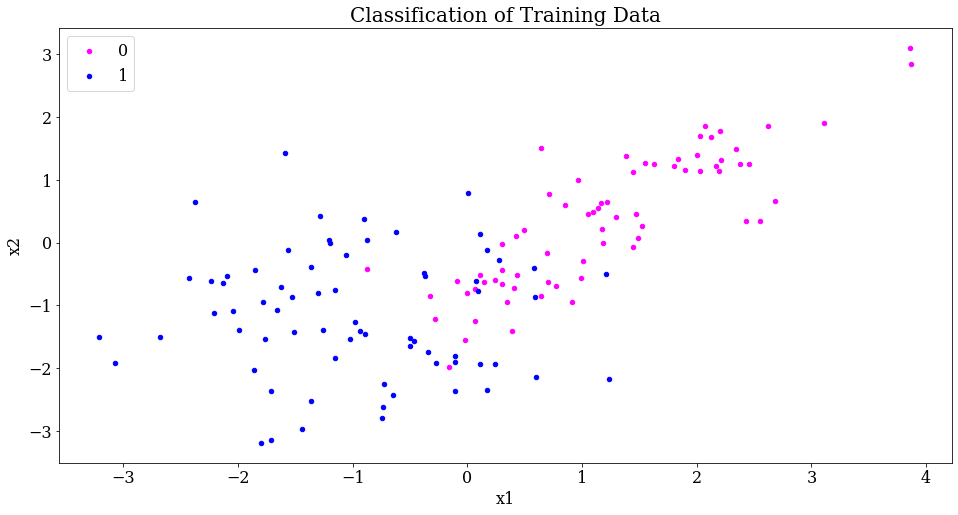

In [4]:
# defining colors for each class
colors = {0:'magenta', 1:'blue' }
fig, ax = plt.subplots(figsize=(16, 8))
grouped = train.groupby('y')

# iterate over groups to format and label each point
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', title= "Random Samples"
    " of Class 0 and Class 1", label=key, color=colors[key])
ax.set_title("Classification of Training Data", fontsize=20)
ax.set_xlabel('x1', fontsize = 16)
ax.set_ylabel('x2', fontsize = 16)
ax.tick_params(labelsize=16)
leg = ax.legend(fontsize = 16)
plt.show()

The plot shows a relatively nice separation of our classifications around an x1 value of 0. Therefore, logistic regression is a good idea for these data because it will be able to find the most optimal position for our threshold between the two classes using gradient descent.

(b) Do the data require any preprocessing due to missing values, scale differences (e.g. different ranges of values), etc.? If so, how did you handle these issues?

In [5]:
missing_train = train.isna().any()
missing_test = test.isna().any()

print("Missing values in training data:\n", missing_train)
print("Missing values in test data:\n", missing_test)

Missing values in training data:
 x1    False
x2    False
y     False
dtype: bool
Missing values in test data:
 x1    False
x2    False
y     False
dtype: bool


There are not any missing values in the data.

In [6]:
p_value = stats.ttest_ind(train.y, test.y)[1]
print("The p-value of class labels: {0:.3f}".format(p_value))

The p-value of class labels: 0.519


The null hypothesis we are testing with this t-test is that there is no difference in class labels between our train and test datasets. If we fail to reject the null hypothesis, we can assume there is balance across the datasets. If we reject the null hypothesis, we can assume there isn't balance across the datasets.

The resulting p-value from our t-test is greater than 0.05 which means we can fail to reject the null hypothesis and have 95% confidence there is balance in our class labels.

### II. Stating the hypothesis set of models to evaluate (we'll use logistic regression)

Given that our data consists of two features, our logistic regression problem will be applied to a two-dimensional feature space. Recall that our logistic regression model is:

$$f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

where the sigmoid function is defined as $\sigma(x) = \dfrac{e^x}{1+e^{x}}= \dfrac{1}{1+e^{-x}}$. Also, since this is a two-dimensional problem, we define $\mathbf{w}^{\top} \mathbf{x}_i = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ and here, $\mathbf{x}_i=[x_{i,0}, x_{i,1}, x_{i,2}]^{\top}$, and $x_{i,0} \triangleq 1$

Remember from class that we interpret our logistic regression classifier output (or confidence score) as the conditional probability that the target variable for a given sample $y_i$ is from class "1", given the observed features, $\mathbf{x}_i$. For one sample, $(y_i, \mathbf{x}_i)$, this is given as:

$$P(Y=1|X=\mathbf{x}_i) = f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

In the context of maximizing the likelihood of our parameters given the data, we define this to be the likelihood function $L(\mathbf{w}|y_i,\mathbf{x}_i)$, corresponding to one sample observation from the training dataset.

*Aside: the careful reader will recognize this expression looks different from when we talk about the likelihood of our data given the true class label, typically expressed as $P(x|y)$, or the posterior probability of a class label given our data, typically expressed as $P(y|x)$. In the context of training a logistic regression model, the likelihood we are interested in is the likelihood function of our logistic regression **parameters**, $\mathbf{w}$. It's our goal to use this to choose the parameters to maximize the likelihood function.*

**No output is required for this section - just read and use this information in the later sections.**

### III. Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data.

**(c)** What is the likelihood function that corresponds to all the $N$ samples in our training dataset that we will wish to maximize? Unlike the likelihood function written above which gives the likelihood function for a *single training data pair* $(y_i, \mathbf{x}_i)$, this question asks for the likelihood function for the *entire training dataset* $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$. 

**(d)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express the likelihood from the last question as a cost function of the model parameters, $C(\mathbf{w})$; that is the negative of the logarithm of the likelihood.

**(e)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$. 

To simplify notation, please use $\mathbf{w}^{\top}\mathbf{x}$ instead of writing out $w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ when it appears each time (where $x_{i,0} = 1$ for all $i$). You are also welcome to use $\sigma()$ to represent the sigmoid function. Lastly, this will be a function the features, $x_{i,j}$ (with the first index in the subscript representing the observation and the second the feature; targets, $y_i$; and the logistic regression model parameters, $w_j$.

**(f)** Write out the gradient descent update equation. This should clearly express how to update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$.  There should be one equation for each model logistic regression model parameter (or you can represent it in vectorized form). Assume that $\eta$ represents the learning rate.

**ANSWER**

**(c)** What is the likelihood function that corresponds to all the $N$ samples in our training dataset that we will wish to maximize? Unlike the likelihood function written above which gives the likelihood function for a *single training data pair* $(y_i, \mathbf{x}_i)$, this question asks for the likelihood function for the *entire training dataset* $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$. 

$L(w|y, x) = \prod_{i=1}^{N} P(x_{i}|p)$

$L(w|y, x) = \prod_{i=1}^{N} P(y_i = 1| x_i)^{y_i}P(y_i = 0 |x_i)^{1-y_i}$

$L(w|y, x) = \prod_{i=1}^{N} \sigma (w^Tx_i)^{y_i}[1 - \sigma(w^Tx_i)]^{1-y_i}$

$L(w|y, x) = \prod_{i=1}^{N} \hat{y}_i ^{y_i}[1-\hat{y}_i]^{1-y_i}$   assuming  $\hat{y}_i \triangleq \sigma(w^\top x_i)$

**(d)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express the likelihood from the last question as a cost function of the model parameters, $C(\mathbf{w})$; that is the negative of the logarithm of the likelihood.

If we take the negative log of both sides:

$-logL(w|y, x) = -log \begin{bmatrix}
\prod_{i=1}^{N} \hat{y}_i ^{y_i}[1-\hat{y}_i]^{1-y_i}
\end{bmatrix}$

$-logL(w|y, x) = 
-\sum _{i=1}^{N} log(\hat{y}_i ^{y_i}[1-\hat{y}_i]^{1-y_i})$

$-logL(w|y, x) = 
-\sum _{i=1}^{N} [y_ilog(\hat{y}_i) +(1-y_i)log(1-\hat{y}_i)]$

We can define our cost function:

$C(w) = -logL(w|y, X)
$

$C(w) =
-\frac{1}{N} \sum _{i=1}^{N} [y_ilog(\hat{y}_i) +(1-y_i)log(1-\hat{y}_i)]$

Substituting back in the sigmoid function:

$C(w) =
-\frac{1}{N} \sum _{i=1}^{N} [y_ilog(\sigma(w^\top x_i)) +(1-y_i)log(1-\sigma(w^\top x_i))]$

**(e)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$. 

$\dfrac{\partial C}{\partial w_j} = -\frac{1}{N} \sum _{i=1}^{N}  y_i \dfrac{1}{\sigma(w^\top x_i)} \dfrac {-e^{-w\top x_i} -x_{ij}}{(1 + e^{-w\top x_i})^2} + (1-y_i)\dfrac{-1}{1-\sigma(w ^\top x_i)} \dfrac{-(-x_{ij}e^{-w^ \top x_i})}{(1 + e^{-w\top x_i})^2}
$

$\dfrac{\partial C}{\partial w_j} = -\frac{1}{N} \sum _{i=1}^{N} y_ix_{ij} \dfrac{1}{\sigma(w^\top x_i)} \dfrac {e^{-w\top x_i} }{1 + e^{-w\top x_i}} \sigma(w^\top x_i) + x_{ij}(1-y_i)\dfrac{-1}{1-\sigma(w ^\top x_i)} \dfrac{e^{-w^ \top x_i}}{(1 + e^{-w\top x_i})
} \sigma(w ^\top x_i)
$

$\dfrac{\partial C}{\partial w_j} = -\frac{1}{N} \sum _{i=1}^{N} y_ix_{ij}(1-\sigma(w^\top x_i)) + x_{ij}(1-y_i)\dfrac{-1}{1-\sigma(w ^\top x_i)} (1-\sigma(w^\top x_i))
 \sigma(w ^\top x_i)
$

$\dfrac{\partial C}{\partial w_j} = -\frac{1}{N} \sum _{i=1}^{N} y_ix_{ij}(1-\sigma(w^\top x_i)) - x_{ij}(1-y_i)\sigma(w^\top x_i)
$

$\dfrac{\partial C}{\partial w_j} = -\frac{1}{N} \sum _{i=1}^{N} y_ix_{ij}-y_ix_{ij}\sigma(w^\top x_i) - x_{ij}\sigma(w^\top x_i) + x_{ij}y_i\sigma(w^\top x_i)
$



$\dfrac{\partial C}{\partial w_j} = -\frac{1}{N} \sum _{i=1}^{N} x_{ij} (y_i - \sigma(w^\top x_i))
$

Written with respect to each of the parameters:

$ \nabla _w C(w) = -\frac{1}{N} [\sum _{i=1}^{N} x_{i0} (y_i - \sigma(w^\top x_i)) , \sum _{i=1}^{N} x_{i1} (y_i - \sigma(w^\top x_i)) , \sum _{i=1}^{N} x_{i2} (y_i - \sigma(w^\top x_i))]
$


**(f)** Write out the gradient descent update equation. This should clearly express how to update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$.  There should be one equation for each model logistic regression model parameter (or you can represent it in vectorized form). Assume that $\eta$ represents the learning rate.

$w ^{(k+1)} = w^{(k)} + \frac{\eta}{N} (\sum _{i=1}^{N} x_{ij} (y_i - \sigma(w^\top x_i)))
$

$w^{(k+1)} = \begin{bmatrix} & w^k_{1} & \\ & w^k_{2} & \\ & w^k_{3} & 
\end{bmatrix} +
\eta \begin{bmatrix} & 
\sum _{i=1}^{N} x_{i0}(y_0 - \sigma(w^\top x_i) &  \\ & 
\sum _{i=1}^{N} x_{i1}(y_1 -\sigma(w^\top x_i) &  \\ & \sum _{i=1}^{N} x_{i2}(y_2 -\sigma(w^\top x_i) & 
\end{bmatrix}
$

### IV. Implement gradient descent and your logistic regression algorithm

**(g)** Implement your logistic regression model. 
- You are provided with a template, below, for a class with key methods to help with your model development. It is modeled on the Scikit-Learn convention. For this, you only need to create a version of logistic regression for the case of two feature variables (i.e. two predictors).
- Create a method called `sigmoid` that calculates the sigmoid function
- Create a method called `cost` that computes the cost function $C(\mathbf{w})$ for a given dataset and corresponding class labels. This should be the **average cost** (make sure your total cost is divided by your number of samples in the dataset).
- Create a method called `gradient_descent` to run **one step** of gradient descent on your training data. We'll refer to this as "batch" gradient descent since it takes into account the gradient based on all our data at each iteration of the algorithm. 
- Create a method called `fit` that fits the model to the data (i.e. sets the model parameters to minimize cost) using your `gradient_descent` method. In doing this we'll need to make some assumptions about the following:
    - Weight initialization. What should you initialize the model parameters to? For this, randomly initialize the weights to a different values between 0 and 1.
    - Learning rate. How slow/fast should the algorithm step towards the minimum? This you will vary in a later part of this problem.
    - Stopping criteria. When should the algorithm be finished searching for the optimum? There are two stopping criteria: small changes in the gradient descent step size and a maximum number of iterations. The first is whether there was a sufficiently small change in the gradient; this is evaluated as whether the magnitude of the step that the gradient descent algorithm takes changes by less than $10^{-6}$ between iterations. Since we have a weight vector, we can compute the change in the weight by evaluating the $L_2$ norm (Euclidean norm) of the change in the vector between iterations. From our gradient descent update equation we know that mathematically this is $||-\eta\nabla_{\mathbf{w}}C(\mathbf{w})||$. The second criterion is met if a maximum number of iterations has been reach (5,000 in this case, to prevent infinite loops from poor choices of learning rates).
    - Design your approach so that at each step in the gradient descent algorithm you evaluate the cost function for both the training and the test data for each new value for the model weights. You should be able to plot cost vs gradient descent iteration for both the training and the test data. This will allow you to plot "learning curves" that can be informative for how the model training process is proceeding.
- Create a method called `predict_proba` that predicts confidence scores (that can be thresholded into the predictions of the `predict` method.
- Create a method called `predict` that makes predictions based on the trained model, selecting the most probable class, given the data, as the prediction, that is class that yields the larger $P(y|\mathbf{x})$.
- (Optional, but recommended) Create a method called `learning_curve` that produces the cost function values that correspond to each step from a previously run gradient descent operation.
- (Optional, but recommended) Create a method called `prepare_x` which appends a column of ones as the first feature of the dataset $\mathbf{X}$ to account for the bias term ($x_{i,1}=1$).

This structure is strongly encouraged; however, you're welcome to adjust this to your needs (adding helper methods, modifying parameters, etc.).

**ANSWER**

In [7]:
# Logistic regression class
class Logistic_regression:
# Class constructor
    def __init__(self):
        self.w = None # logistic regression weights
        self.saved_w = [] 
        # Since this is a small problem, we can save the weights
        # at each iteration of gradient descent to build our 
        # learning curves
        pass # returns nothing

    def prepare_x(self, X):
        # returns the X with a new feature of all ones 
        # (a column that is the new column 0)
        X = np.c_[np.ones(X.shape[0]),X]
        return X

    # Method for calculating the sigmoid function of 
    # w^T X for an input set of weights
    def sigmoid(self, X):
        X = X.transpose()
        z = self.w@X
        # returns the value of the sigmoid
        return 1/(1 + np.exp(-z))

    # Cost function for an input set of weights
    def cost(self, X, y):
        n = len(y)
        pred = self.sigmoid(X)
        # returns the average cross entropy cost
        cost = sum((y*np.log(pred))) + sum(((1-y)*np.log(1-pred)))
        cost = -cost/n # remember to divide by n
        return cost

    # Update the weights in an iteration of gradient descent
    def gradient_descent(self, X, y, lr): # lr is the learning rate
        pred = self.sigmoid(X)
        d = y-pred.T
        summation= X.T@d
        self.w = self.w + lr*summation
        delta = np.linalg.norm(lr*summation)
        # returns s scalar of the magnitude of the Euclidean norm (l2)
        # the change in the weights during one gradient descent step
        return delta
        

    # Fit the logistic regression model to the data through gradient descent
    def fit(self, X, y, w_init, lr, delta_thresh=1e-6, max_iter=5000, verbose=False):
        # Note the verbose flag enables you to print out the weights at each iteration 
        # w_init is initializing the weights outside of the class 
        # (random values for feature 1, 2 and intercept)
        # call self.w = w_init    
        self.w = w_init
        self.saved_w.append(self.w)

        for i in range(max_iter):  # ensure iterations don't exceed 5000
            delta = self.gradient_descent(X,y,lr)
            if delta > delta_thresh: # delta threshold is 1e-6
                # append new weights to self.saved_w
                self.saved_w.append(self.w)
            else:
                break
        pass # returns nothing

    # Use the trained model to predict the confidence scores 
    # (prob of positive class in this case)
    def predict_proba(self, X):
        # returns the confidence score for the each sample
        # fitting x into sigmoid function
        return self.sigmoid(X)
        
    # Use the trained model to make binary predictions
    def predict(self, X, thresh=0.5):
        preds = self.predict_proba(X)
        # returns a binary prediction for each sample
        # zeros or ones
        preds[preds>thresh] = 1
        preds[preds<=thresh] = 0
        return preds

    # Stores the learning curves from saved weights from gradient descent
    def learning_curve(self, X, y):        
        cost_list = []
         # loop through saved weights 
        for i in self.saved_w:
            self.w = i
            # returns the value of the cost function (self.cost) 
            # from each step in gradient descent
            # from the last model fitting process
            cost = self.cost(X,y)
            cost_list.append(cost) # save to a cost list
        return cost_list

**(h)** Choose a learning rate and fit your model. Learning curves are a plot of metrics of model performance evaluated through the process of model training to provide insight about how model training is proceeding. Show the learning curves for the gradient descent process for learning rates of $\{10^{-2}, 10^{-4}, 10^{-6}\}$. For each learning rate plot the learning curves by plotting **both the training and test data average cost** as a function of each iteration of gradient descent. You should run the model fitting process until it completes (up to 5,000 iterations of gradient descent). Each of the 6 resulting curves (train and test average cost for each learning rate) should be plotted on the same set of axes for direct comparison. *Note: make sure you're using average cost per sample, not total cost*

**ANSWER**

In [8]:
# prepare the data to be used in the model
w= np.array([1,1,1]) # initializing the weights as 1, 1, 1
X = data.iloc[:,:2].values
y = data.iloc[:,2].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3
    ,random_state=123)

# initialize the model and prepare X for training and testing
Sydneys_model = Logistic_regression()
X_train_new = Sydneys_model.prepare_x(X_train)
X_test_new = Sydneys_model.prepare_x(X_test)

<Figure size 1008x720 with 0 Axes>

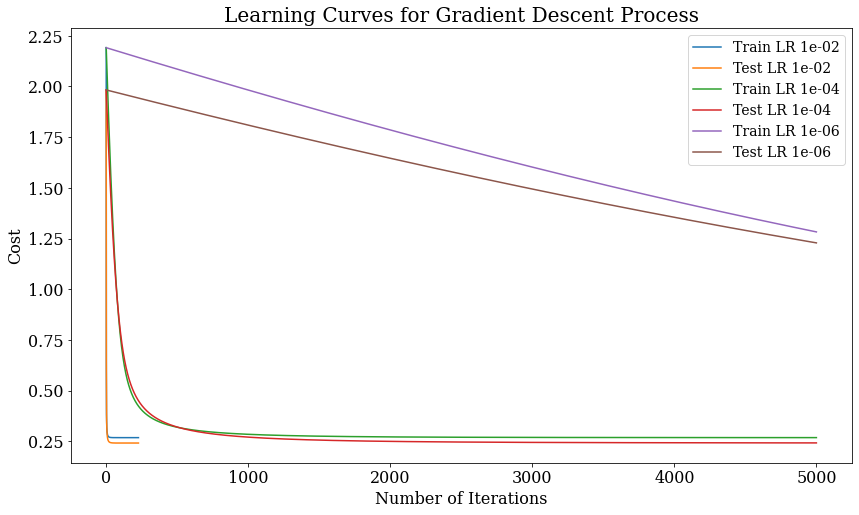

In [9]:
# plotting number of iterations for 3 different learning rates
fig = plt.figure(figsize=(14, 10))
rates = np.array([10**-2, 10**-4, 10**-6])

fig, ax = plt.subplots(figsize=(14, 8))

for i in range(len(rates)):
    lr_model=Logistic_regression()
    lr_model.fit(X_train_new, y_train,w,rates[i])
    train_cost = lr_model.learning_curve(X_train_new, y_train)
    test_cost = lr_model.learning_curve(X_test_new, y_test)
    plt.plot(range(len(train_cost)),train_cost,
            label="Train LR {:.0e}".format(rates[i]))
    plt.plot(range(len(test_cost)),test_cost,
            label="Test LR {:.0e}" .format(rates[i]))
            
plt.legend()
plt.xlabel("Number of Iterations", fontsize=16)
plt.ylabel("Cost", fontsize=16)
plt.title("Learning Curves for Gradient Descent Process", fontsize=20)
leg = ax.legend(fontsize = 14, loc='upper right')
ax.tick_params(labelsize=16)
plt.show()

Try running this process for a really big learning rate for this problem: $10^0$. Look at the weights that the fitting process generates over the first 50 iterations and how they change. You may simply print these first 50 iterations as output or plot them. What happens and why?

No handles with labels found to put in legend.


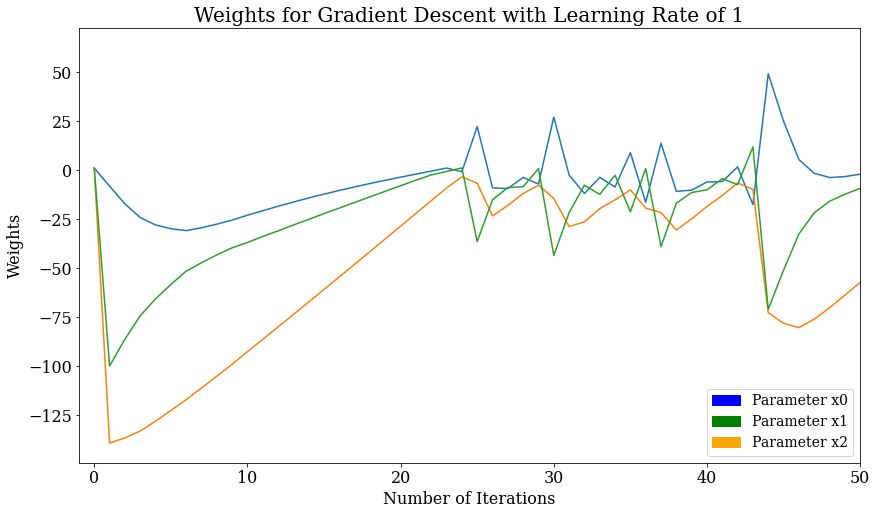

In [10]:
# plotting number of iterations for large learning rate
fig, ax = plt.subplots(figsize=(14, 8))


lr_model=Logistic_regression()
lr_model.fit(X_train_new, y_train,w,10**0)
weights = lr_model.saved_w
plt.plot(weights)
plt.legend()
plt.xlabel("Number of Iterations", fontsize=16)
plt.ylabel("Weights", fontsize=16)
plt.title("Weights for Gradient Descent with Learning Rate of 1", fontsize=20)

colors = {'Parameter x0':'blue', 'Parameter x1':'green'
            , 'Parameter x2':'orange'}        
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

ax.legend(handles, labels, fontsize = 14, loc='lower right')
ax.tick_params(labelsize=16)

plt.xlim(-1,50)
plt.show()

- We can see that for each parameter, the weights make very large jumps from negative to positive values, rather than slowly approach a minimum as they should. Normally with gradient descent, we start at an initial point and want to “roll” down to the minimum. The gradient points in the direction of steepest positive change, and we move in the opposite direction of the gradient. If we were looking at a plot of the gradient descent parabola, this would normally look like small hops down one side of the gradient parabola.  However, with a learning rate of 1, this would look like jumping from left to right across the y-axis and we would not get any closer to the minimum after each iteration.

What is the impact that the different values of learning has on the speed of the process and the results?

- Learning rates have a huge impact on the speed and process of a gradient descent update equation. We see that as learning rates get smaller, the required number of iterations to approach the minimum increases.  On the other hand, if learning rates are too large, we aren't able to approach the minimum.  We have to try to find the ideal learning rate that lies in the middle of these two extremes.

Of the options explored, what learning rate do you prefer and why? Use your chosen learning rate for the remainder of this problem.

- I prefer a learning rate of $10^{-2}$ because it approaches the minimum with the least number of iterations and has the minimum cost as well.

### V. Evaluate your model performance through cross validation

**(i)** Test the performance of your trained classifier using K-folds cross validation resampling technique. The scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful. 
- Train your logistic regression model and a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.
- Using the trained models, make two plots corresponding to each model (logistic regression and KNN): one with the training data, and one for the test data. On each plot, include the decision boundary resulting from your trained classifier.
- Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds. 
  - Plot these curves on the same set of axes to compare them
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.
- Comment on the following:
  - What is the purpose of using cross validation for this problem?
  - How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

**ANSWER**

Train your logistic regression model and a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.

In [11]:
# train logistic regression model
w= np.array([1,1,1]) # initializing the weights as 1, 1, 1
X = data.iloc[:,:2].values
y = data.iloc[:,2].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3
    ,random_state=123)

lr_model=Logistic_regression()
X_train_new = lr_model.prepare_x(X_train)
lr_model.fit(X_train_new, y_train,w,10**-2)

In [12]:
# train knn model
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

Using the trained models, make two plots corresponding to each model (logistic regression and KNN): one with the training data, and one for the test data. On each plot, include the decision boundary resulting from your trained classifier.

In [13]:
# prepare the labels for plotting
train_data_label1 = train.loc[train["y"] == 1]
train_data_label0 = train.loc[train["y"] == 0]

test_data_label1 = test.loc[test["y"] == 1]
test_data_label0 = test.loc[test["y"] == 0]

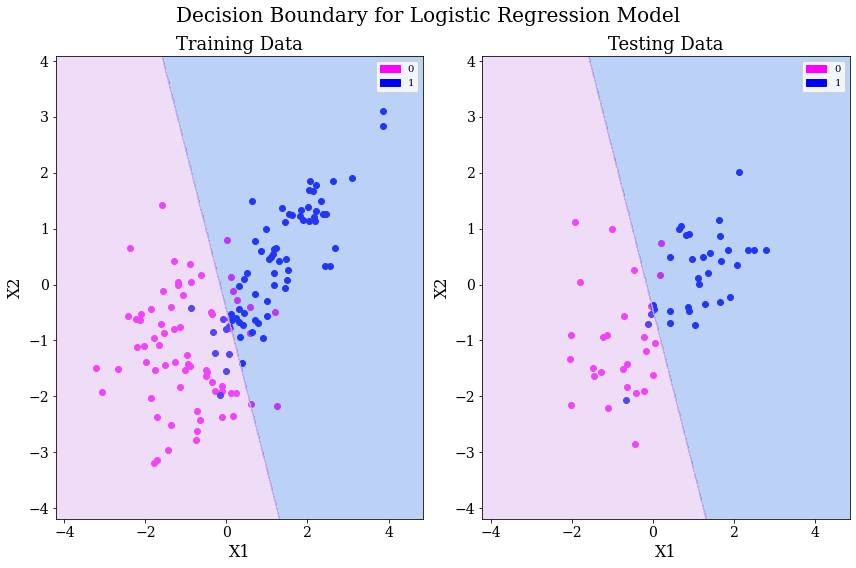

In [15]:
# create the plot for the Logistic Regression Model
h=0.02

fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle("Decision Boundary for Logistic Regression Model", fontsize=20)

ax[0].scatter(
    train_data_label1["x1"], 
    train_data_label1["x2"],
    color="magenta", 
    label="Class 1"
)
ax[0].scatter(
    train_data_label0["x1"],
    train_data_label0["x2"],
    color="blue",
    label="Class 0",
)

ax[1].scatter(
    test_data_label1["x1"], 
    test_data_label1["x2"],
    color="magenta", 
    label="Class 1"
)
ax[1].scatter(
    test_data_label0["x1"],
    test_data_label0["x2"],
    color="blue",
    label="Class 0",
)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min_1, x_max_1 = X_train_new[:, 1].min() - 1, X_train_new[:, 1].max() + 1
x_min_2, x_max_2 = X_train_new[:, 2].min() - 1, X_train_new[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min_1, x_max_1, h),
                        np.arange(x_min_2, x_max_2, h))
Z = np.c_[xx.ravel(), yy.ravel()]
Z_prep = lr_model.prepare_x(Z)
boundary = lr_model.predict(Z_prep).reshape(xx.shape)

# creating the background colors
cmap_light = ListedColormap(['#558CE6', '#D8ABEB'])
ax[0].contourf(xx, yy, boundary, cmap=cmap_light, alpha=0.4)
ax[1].contourf(xx, yy, boundary, cmap=cmap_light, alpha=0.4)

#creating the legends
label_pink = mpatches.Patch(color= "magenta", label="0", hatch="o")
label_blue = mpatches.Patch(color="blue", label="1", hatch="o")
ax[0].legend(handles=[label_pink,label_blue],loc='best')
ax[1].legend(handles=[label_pink,label_blue],loc='best')


# creating the labels and titles
ax[0].set_title("Training Data", fontsize=18)
ax[1].set_title("Testing Data", fontsize=18)
ax[0].set_xlim(xx.min(), xx.max())
ax[0].set_ylim(yy.min(), yy.max())
ax[0].set_xlabel("X1", fontsize=16)
ax[0].set_ylabel("X2", fontsize=16)
ax[1].set_xlabel("X1", fontsize=16)
ax[1].set_ylabel("X2", fontsize=16)
ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)

fig.tight_layout()
plt.show()

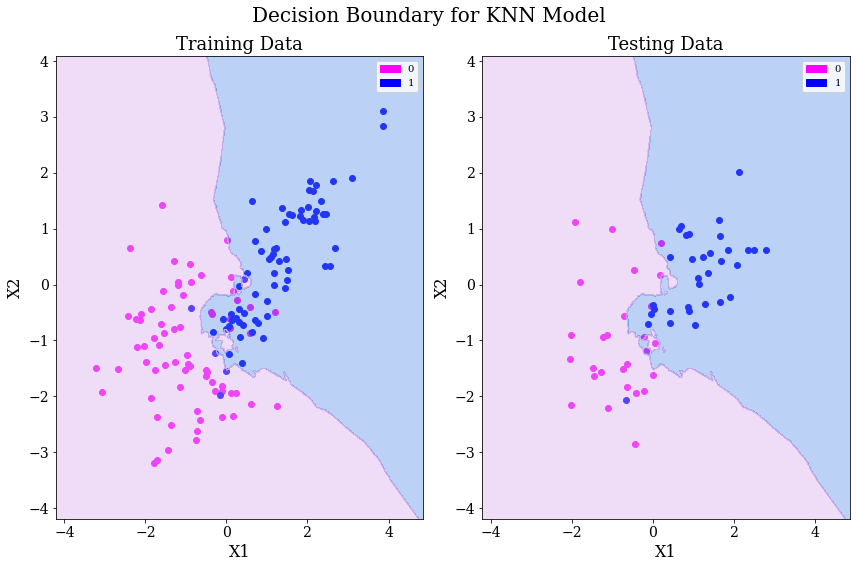

In [70]:
# create the plot for the KNN Model
h=0.02

fig, ax = plt.subplots(1,2,figsize=(12,8))
fig.suptitle("Decision Boundary for KNN Model", fontsize=20)


ax[0].scatter(
    train_data_label1["x1"], 
    train_data_label1["x2"],
    color="magenta", 
    label="Class 1"
)
ax[0].scatter(
    train_data_label0["x1"],
    train_data_label0["x2"],
    color="blue",
    label="Class 0",
)

ax[1].scatter(
    test_data_label1["x1"], 
    test_data_label1["x2"],
    color="magenta", 
    label="Class 1"
)
ax[1].scatter(
    test_data_label0["x1"],
    test_data_label0["x2"],
    color="blue",
    label="Class 0",
)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min_0, x_max_0 = X[:, 0].min() - 1, X[:, 0].max() + 1
x_min_1, x_max_1 = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min_0, x_max_0, h),
                        np.arange(x_min_1, x_max_1, h))

Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# creating the background colors
cmap_light = ListedColormap(['#558CE6', '#D8ABEB'])
ax[0].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)
ax[1].contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)

#creating the legends
label_pink = mpatches.Patch(color= "magenta", label="0", hatch="o")
label_blue = mpatches.Patch(color="blue", label="1", hatch="o")
ax[0].legend(handles=[label_pink,label_blue],loc='best')
ax[1].legend(handles=[label_pink,label_blue],loc='best')


# creating the labels and titles
ax[0].set_title("Training Data", fontsize=18)
ax[1].set_title("Testing Data", fontsize=18)
ax[0].set_xlabel("X1", fontsize=16)
ax[0].set_ylabel("X2", fontsize=16)
ax[1].set_xlabel("X1", fontsize=16)
ax[1].set_ylabel("X2", fontsize=16)
ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)

fig.tight_layout()
plt.show()

Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds. 
  - Plot these curves on the same set of axes to compare them
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.

In [16]:
# train logistic regression and KNN using cross-validation
cv = StratifiedKFold(n_splits=10)

# create empty lists to store the results of each fold
lr_preds = []
knn_preds = []
lr_probs = []
knn_probs = []
lr_roc_auc = []
knn_roc_auc = []
y_test_new = []

X=data[["x1","x2"]].values
y=data[["y"]].values.ravel()

for train_index, test_index in cv.split(X, y):
    # split the data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # append to y_test_new
    y_test_new.append(y_test)
    # initialize the models
    lr_model = Logistic_regression()
    knn_model = KNeighborsClassifier(n_neighbors=7)
    # prepare X for lr_model training and testing 
    X_train_cv = lr_model.prepare_x(X_train)
    X_test_cv = lr_model.prepare_x(X_test)
    # fit the models
    lr_model.fit(X_train_cv, y_train, w, 10**-2)
    knn_model.fit(X_train, y_train)
    # append the predictions to the list
    lr_preds.append(lr_model.predict(X_test_cv))
    knn_preds.append(knn_model.predict(X_test))
    # append the probs to the list
    lr_probs.append(lr_model.predict_proba(X_test_cv))
    knn_probs.append(np.array(knn_model.predict_proba(X_test)[:,1]))

In [17]:
# concatenate all 10 models into one array
lr_probs_x10 = np.array(lr_probs).flatten()
knn_probs_x10 = np.array(knn_probs).flatten()
y_test_x10 = np.array(y_test_new).flatten()

# roc curves
lr_fpr,lr_tpr,threshold = roc_curve(y_test_x10, lr_probs_x10)
knn_fpr,knn_tpr,threshold = roc_curve(y_test_x10, knn_probs_x10)

# auc's
lr_roc_auc = auc(lr_fpr, lr_tpr)
knn_roc_auc = auc(knn_fpr, knn_tpr)

<function matplotlib.pyplot.show(close=None, block=None)>

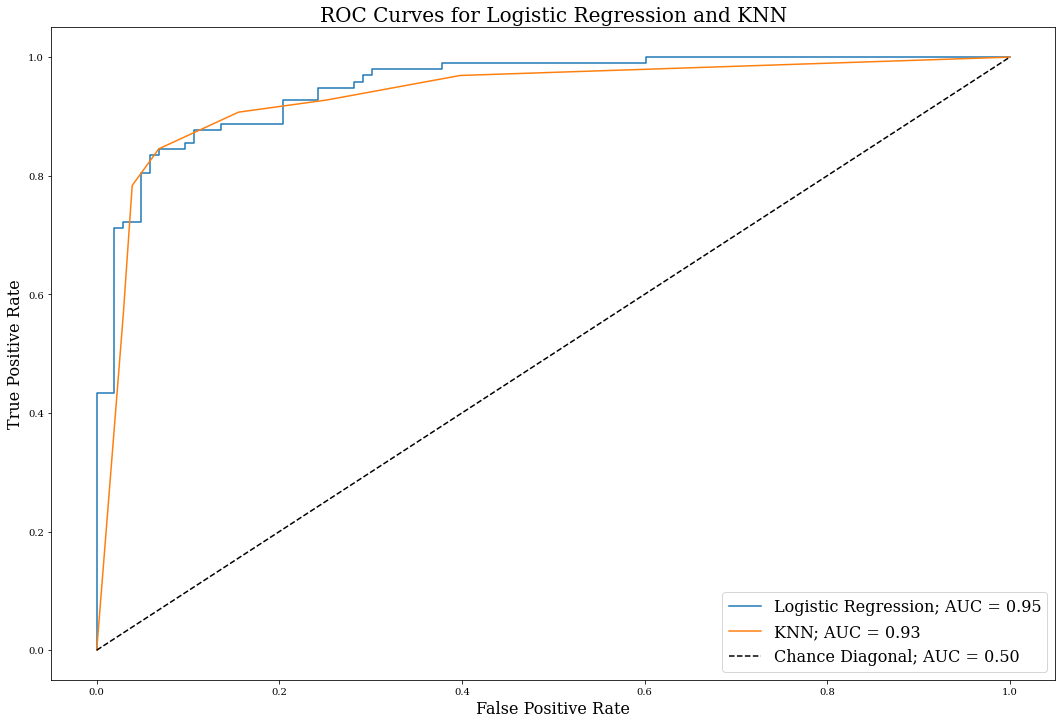

In [18]:
# plot the roc curves
fig, ax = plt.subplots(figsize=(18,12))
plt.plot(lr_fpr,lr_tpr, label="Logistic Regression; AUC = %0.2f" % lr_roc_auc)
plt.plot(knn_fpr,knn_tpr, label="KNN; AUC = %0.2f" % knn_roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label="Chance Diagonal; AUC = %0.2f" % 0.5)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curves for Logistic Regression and KNN", fontsize=20)
plt.legend(loc='lower right', fontsize=16)
plt.show

What is the purpose of using cross validation for this problem?

- Cross validation is primarily used for 2 reasons:

    1. To ensure and test the generalizability of a model- so that we do not choose a high variance model that might overfit on our training dataset. Thus, it helps preventing overfitting.
    2. To find and select the best hyperparameters for a model in order to reduce error and bias.

How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

# 2

## Digits classification
**[30 points]**

*An exploration of regularization, imbalanced classes, ROC and PR curves*

The goal of this exercise is to apply your supervised learning skills on a very different dataset: in this case, image data; MNIST: a collection of images of handwritten digits. Your goal is to train a classifier that is able to distinguish the number "3" from all possible numbers and to do so as accurately as possible. You will first explore your data (this should always be your starting point to gain domain knowledge about the problem.). Since the feature space in this problem is 784-dimensional, overfitting is possible. To avoid overfitting you will investigate the impact of regularization on generalization performance (test accuracy) and compare regularized and unregularized logistic regression model test error against other classification techniques such as linear discriminant analysis and random forests and draw conclusions about the best-performing model.

Start by loading your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, using the code provided below. MNIST has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

Your goal is to classify whether or not an example digit is a 3. Your binary classifier should predict $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format (3's are class 1, and all other digits are class 0). 

**(a)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.
- Note that the data are composed of samples of length 784. These represent 28 x 28 images, but have been reshaped for storage convenience. To plot digit examples, you'll need to reshape the data to be 28 x 28 (which can be done with numpy `reshape`).

**(b)** How many examples are present in each class? Show a plot of samples by class (bar plot). What fraction of samples are positive? What issues might this cause?

**(c)** Using a logistic regression classifier, apply lasso regularization and retrain the model and evaluate its performance over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. Vary the value of C logarithmically from $10^{-4}$ to $10^4$ (and make your x-axes logarithmic in scale) and evaluate it at 20 different values of C. As you vary the regularization coefficient, Plot 
- The number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)
- The cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)
- Area under the ROC curve (AUC)
- The $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.
- Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

**(d)** Train and test a (1) logistic regression classifier with minimal regularization (using the Scikit Learn package, set penalty='l1', C=1e100 to approximate this), (2) a logistic regression classifier with the best value of the regularization parameter from the last section, (3) a Linear Discriminant Analysis (LDA) Classifier, and (4) a Random Forest (RF) classifier (using default parameters for the LDA and RF classifiers). 
- Compare your classifiers' performance using ROC and Precision Recall (PR) curves. 
- Plot the line that represents randomly guessing the class (50% of the time a "3", 50% not a "3"). You SHOULD NOT actually create random guesses. Instead you should think through the theory behind how ROC and PR curves work and plot the appropriate lines. It's a good practice to include these in ROC and PR curve plots as a reference point.
- For PR curves, an excellent resource on how to correctly plot them can be found [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) (ignore the section on "non-linear interpolation between two points"). This describes how a random classifier is represented in PR curves and demonstrates that it should provide a lower bound on performance.
- When training your logistic regression model, it's recommended that you use solver="liblinear"; otherwise your results may not converge
- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

In [19]:
# Load the MNIST Data
# Set this to True to download the data for the first time 
# and False after the first time so that you just load the 
# data locally instead of downloading it again
download_data = False

if download_data:
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
    
    # Adjust the labels to be '1' if y==3, and '0' otherwise
    y[y!='3'] = 0
    y[y=='3'] = 1
    y = y.astype('int')
    
    # Divide the data intro a training and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7
        , random_state=88)
    
    file = open('tmpdata', 'wb')
    pickle.dump((X_train, X_test, y_train, y_test), file)
    file.close()
else:
    file = open('tmpdata', 'rb')
    X_train, X_test, y_train, y_test = pickle.load(file)
    file.close()

**ANSWER**

**(a)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.

In [20]:
images_to_plot = 10
indexThreesList = [ i for i in range(len(y_train)) if y_train[i] == 1 ]
indexNonThreesList = [ i for i in range(len(y_train)) if y_train[i] == 0 ]
random.seed(123)
random_indices3 = random.sample(indexThreesList, images_to_plot)
random_indicesNon3 = random.sample(indexNonThreesList, images_to_plot)
random_indices= random_indices3+random_indicesNon3
sample_images = pd.DataFrame(X_train).loc[random_indices, :]
sample_labels = pd.DataFrame(y_train).loc[random_indices]

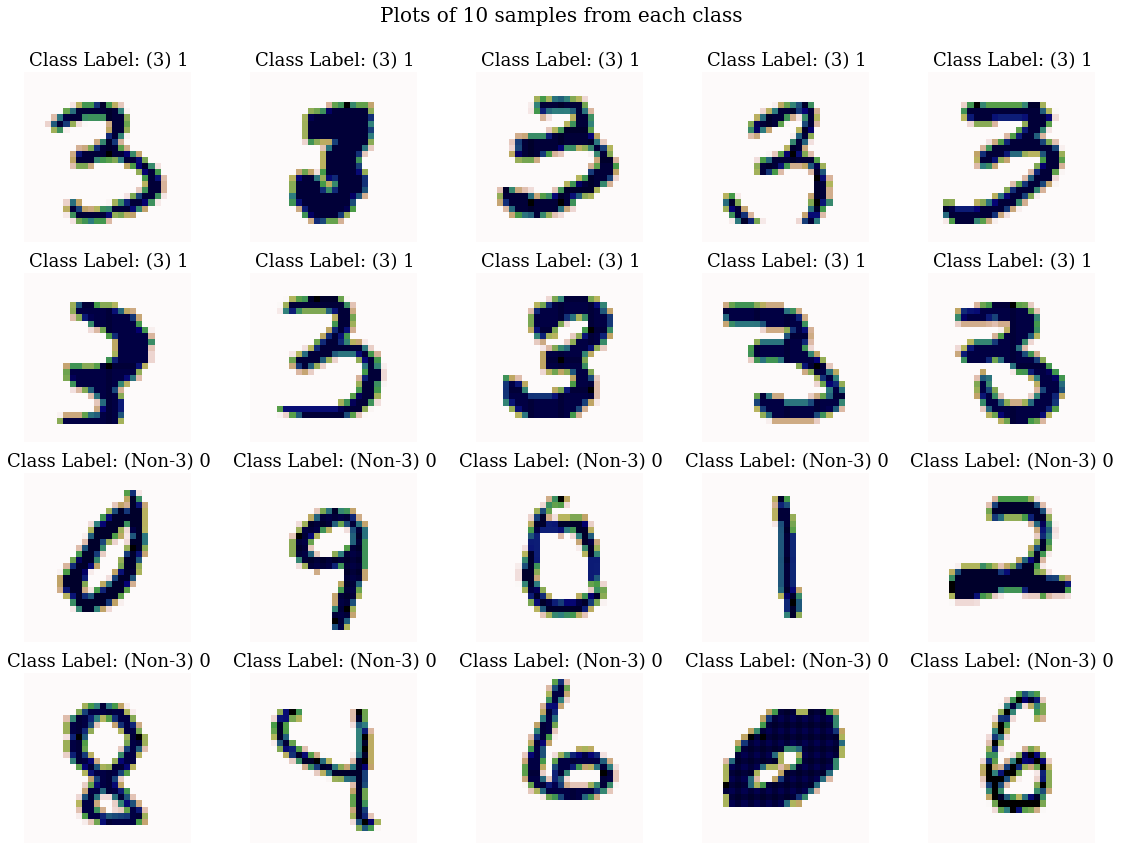

In [21]:
fig = plt.figure(figsize=(16, 12))
for idx in range (len(random_indices)):
    im_idx=random_indices[idx]
    plottable_image = np.reshape(X_train[im_idx], (28, 28))
    ax = fig.add_subplot(4, 5, idx+1)
    ax.imshow(plottable_image, cmap='gist_earth_r')
    if sample_labels.iloc[idx][0]==1:
        ax.set_title('Class Label: (3) {}'.format(sample_labels.iloc[idx][0])
        , fontsize=18)
    else:
        ax.set_title('Class Label: (Non-3) {}'.format(sample_labels.iloc[idx][0])
        , fontsize=18)
    ax.set_xbound([0,28])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.axis('off')
plt.suptitle('Plots of 10 samples from each class\n', fontsize=20)
plt.tight_layout()
plt.show()

**(b)** How many examples are present in each class? Show a plot of samples by class (bar plot). What fraction of samples are positive? What issues might this cause?

In [22]:
# create training dataframe for plotting
y_train_df = pd.DataFrame(y_train)
y_train_df[0] = y_train_df[0].astype('category')

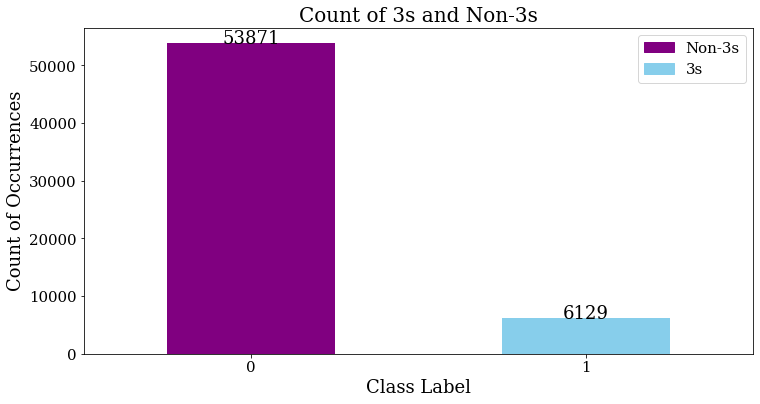

In [23]:
fig, ax = plt.subplots()

y_train_df[0].value_counts().plot(
    kind='bar'
    , figsize=(12,6), fontsize=15, color=['purple','skyblue']
    , rot=0)
plt.title('Count of 3s and Non-3s', fontsize=20)
plt.xlabel("Class Label", fontsize=18)
plt.ylabel("Count of Occurrences", fontsize=18)

values = [y_train_df[0].value_counts()[0], y_train_df[0].value_counts()[1]]
for index, data in enumerate(values):
    plt.text(x=index , y =data, s=data , horizontalalignment='center', fontsize=18)

colors = {'Non-3s':'purple', '3s':'skyblue'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc='upper right', fontsize=15)
plt.show()

In [24]:
fraction_3s = y_train_df[0].value_counts()[1] / (y_train_df[0].value_counts()[0] \
    + y_train_df[0].value_counts()[1])*10
percent_3s = y_train_df[0].value_counts()[1] / (y_train_df[0].value_counts()[0] \
    + y_train_df[0].value_counts()[1])*100

print('Fraction of samples positively labeled as 3s: {:.0f}/10'.format(fraction_3s))
print('Percent of samples positively labeled as 3s: {:.02f}%'.format(percent_3s))

Fraction of samples positively labeled as 3s: 1/10
Percent of samples positively labeled as 3s: 10.21%


There is an imbalance of classes with more data points in the negative class. This is an issue because when we train our model on this data, it will put a large weight on the negative class. Then when we fit our model to unseen data, it will be more likely to assign a negative class to an observation even if it should be positive.

**(c)** Using a logistic regression classifier, apply lasso regularization and retrain the model and evaluate its performance over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. Vary the value of C logarithmically from $10^{-4}$ to $10^4$ (and make your x-axes logarithmic in scale) and evaluate it at 20 different values of C. As you vary the regularization coefficient, Plot 
- The number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)
- The cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)
- Area under the ROC curve (AUC)
- The $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.
- Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

In [25]:
# create function to run logistic regression
def clf_lr (X_train, y_train, X_test, c):
    lasso = linear_model.LogisticRegression(solver='liblinear'
    , penalty= 'l1', C=c).fit(X_train, y_train)
    return lasso.predict_proba(X_test)[:,1], lasso.coef_

In [26]:
# create empty lists to append the results of the logistic regression
nonzero_coef = []
losses = []
f1s = []
roc_auc = []

# get random values for the regularization parameter
np.random.seed(123)
c_vals = np.logspace(-4,4,20)

# iterate through the values of the regularization parameter
for i in c_vals:
    prob, coef = clf_lr(X_train, y_train, X_test, c=i)
    # non-zero parameters
    nonzero_coef.append(len(coef[0]) - list(coef[0]).count(0.0))
    # loss values
    losses.append(log_loss(y_test, prob))
    # f1-scores
    f1s.append(f1_score(y_test, prob>0.5))
    # aucs
    fpr,tpr,threshold = roc_curve(y_test, prob)
    roc_auc.append(auc(fpr,tpr))

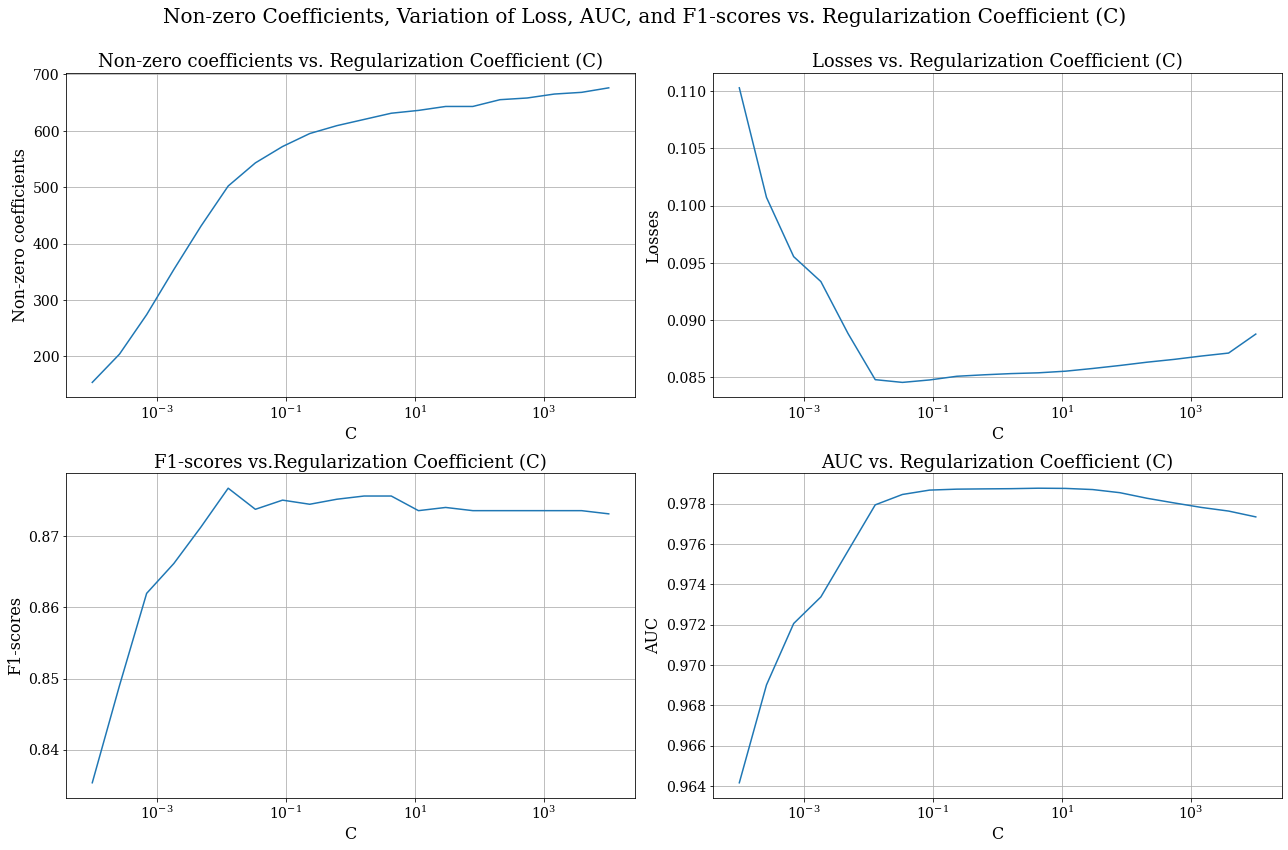

In [27]:
# plotting the results
fig, ax = plt.subplots(2,2,figsize=(18,12))

ax[0,0].plot(c_vals,nonzero_coef)
ax[0,0].set_xlabel("C", fontsize=16)
ax[0,0].set_ylabel("Non-zero coefficients", fontsize=16)
ax[0,0].set_title("Non-zero coefficients vs. Regularization Coefficient (C)"
    , fontsize=18)
ax[0,0].set_xscale('log')
ax[0,0].tick_params(labelsize=14)
ax[0,0].grid()

ax[0,1].plot(c_vals,losses)
ax[0,1].set_xlabel("C", fontsize=16)
ax[0,1].set_ylabel("Losses", fontsize=16)
ax[0,1].set_title("Losses vs. Regularization Coefficient (C)", fontsize=18)
ax[0,1].set_xscale('log')
ax[0,1].tick_params(labelsize=14)
ax[0,1].grid()

ax[1,0].plot(c_vals,f1s)
ax[1,0].set_xlabel("C", fontsize=16)
ax[1,0].set_ylabel("F1-scores", fontsize=16)
ax[1,0].set_title("F1-scores vs.Regularization Coefficient (C)", fontsize=18)
ax[1,0].set_xscale('log')
ax[1,0].tick_params(labelsize=14)
ax[1,0].grid()

ax[1,1].plot(c_vals,roc_auc)
ax[1,1].set_xlabel("C", fontsize=16)
ax[1,1].set_ylabel("AUC", fontsize=16)
ax[1,1].set_title("AUC vs. Regularization Coefficient (C)", fontsize=18)
ax[1,1].set_xscale('log')
ax[1,1].tick_params(labelsize=14)
ax[1,1].grid()

fig.suptitle("Non-zero Coefficients, Variation of Loss, AUC, and F1-scores vs. "
"Regularization Coefficient (C)\n", fontsize=20)
plt.tight_layout()
plt.show()

The value of C that seems the best for this problem is somewhere around $10^{-2}$. This is because we minimize our losses at this point, while maximizing our non-zero coefficients, F1-scores, and AUC.

**(d)** Train and test a (1) logistic regression classifier with minimal regularization (using the Scikit Learn package, set penalty='l1', C=1e100 to approximate this), (2) a logistic regression classifier with the best value of the regularization parameter from the last section, (3) a Linear Discriminant Analysis (LDA) Classifier, and (4) a Random Forest (RF) classifier (using default parameters for the LDA and RF classifiers). 
- Compare your classifiers' performance using ROC and Precision Recall (PR) curves. 
- Plot the line that represents randomly guessing the class (50% of the time a "3", 50% not a "3"). You SHOULD NOT actually create random guesses. Instead you should think through the theory behind how ROC and PR curves work and plot the appropriate lines. It's a good practice to include these in ROC and PR curve plots as a reference point.
- For PR curves, an excellent resource on how to correctly plot them can be found [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) (ignore the section on "non-linear interpolation between two points"). This describes how a random classifier is represented in PR curves and demonstrates that it should provide a lower bound on performance.
- When training your logistic regression model, it's recommended that you use solver="liblinear"; otherwise your results may not converge
- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

In [28]:
minimal_reg = linear_model.LogisticRegression(solver="liblinear", penalty="l1"
    , C=10**100).fit(
    X_train, y_train)
best_reg = linear_model.LogisticRegression(solver="liblinear", penalty="l1"
    , C=10**-2).fit(
    X_train, y_train)
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
random_forest = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [29]:
models = [minimal_reg , best_reg, lda, random_forest]

In [68]:
def test_classifiers(X_test, y_test, models):
    fig, ax = plt.subplots(1,2,figsize=(14,12))
    for i in range(len(models)):
        prob = models[i].predict_proba(X_test)[:,1]
        fpr,tpr,threshold = roc_curve(y_test, prob)

        colors = ['green', 'blue', 'red', 'orange']
        # ROC curve
        ax[0].plot(fpr,tpr,c=colors[i])
        ax[0].set_xlabel("False Positive Rate", fontsize=16)
        ax[0].set_ylabel("True Positive Rate", fontsize=16)
        ax[0].set_title("ROC Curve", fontsize=18)
        ax[0].tick_params(labelsize=16)
        ax[0].grid()

        precision, recall, threshold = precision_recall_curve(y_test, prob)
        neg = np.sum(y_test == 0)
        pos = np.sum(y_test == 1)
        baseline = pos/(neg+pos)

        # precision-recall curve
        ax[1].plot(recall,precision, c=colors[i])
        ax[1].set_xlabel("Precision", fontsize=16)
        ax[1].set_ylabel("Recall", fontsize=16)
        ax[1].set_title("Precision Recall Curve", fontsize=18)
        ax[1].tick_params(labelsize=16)
        ax[1].grid()

        colors = {'Minimal Regularization':'green', 'Best Regularization':'blue'
            , 'LDA':'red', 'Random Forest':'orange'}        
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label 
            in labels]
        

        fig.suptitle("ROC and Precision Recall Curves\n", fontsize=20)
        fig.tight_layout()
    
    ax[0].plot([0, 1], [0, 1], 'k--', label = 'Random Guess')
    ax[1].plot(np.arange(0,1.5, 0.5), np.repeat(baseline, 3), 'k--', label="Baseline")
    ax[0].legend(loc='lower right', fontsize=16)
    ax[1].legend(loc='lower right', fontsize=16)

    fig.legend(handles, labels, loc='upper center', fontsize=16, bbox_to_anchor=(1.1, 1.05))
    plt.show()

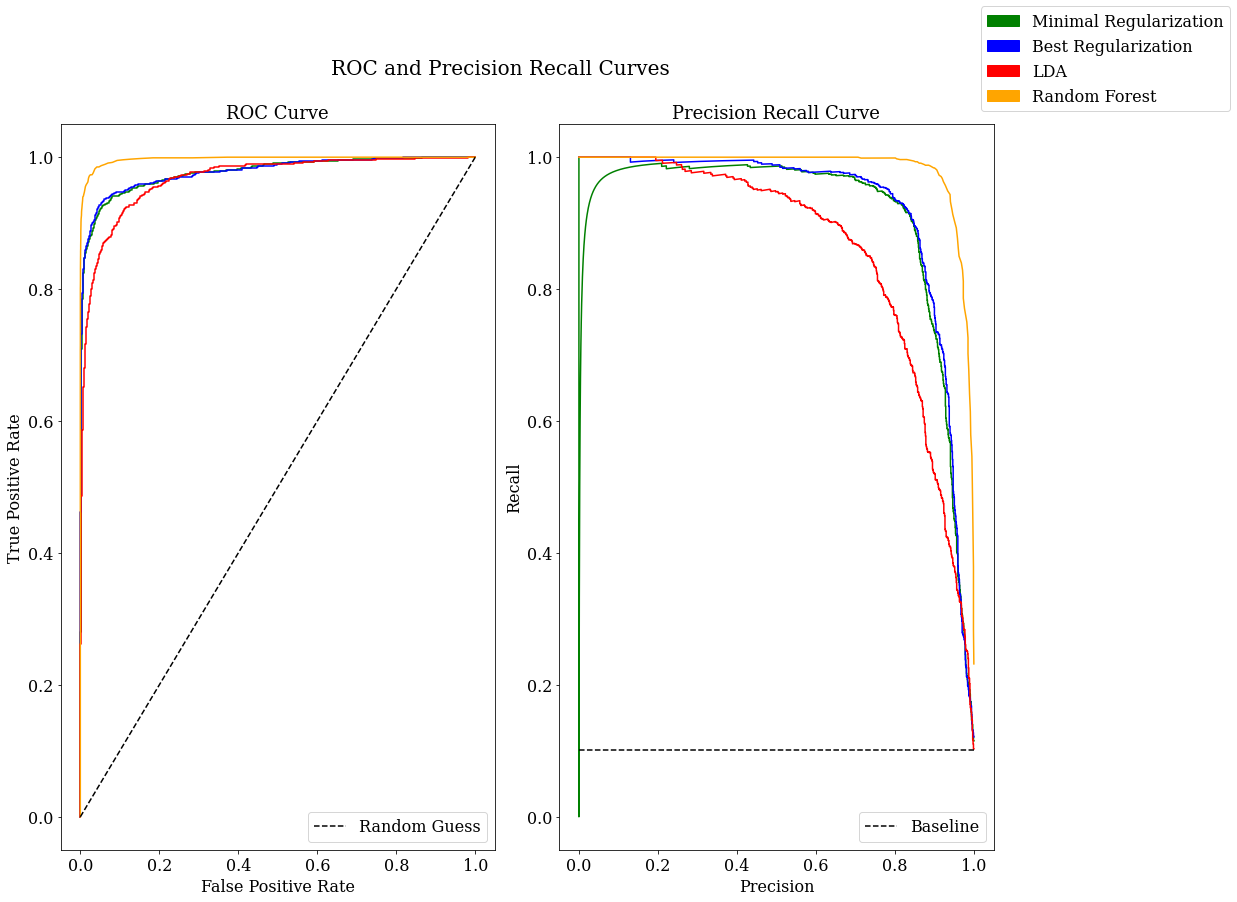

In [69]:
test_classifiers(X_test, y_test, models)

Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

- For an ROC curve, the most ideal curve is one that reaches the top left corner, and for the Precision Recall curve, the most ideal is a curve that reaches the top right corner. We can see that regularization of the logistic regression model does not make much of a difference because whether there was minimal or the best regularization, the curves look about the same. The random forest is the best classifier in this case because it had an ROC curve and a Precision Recall curve that most closely aligns with what we would consider ideal.